In [1]:
import os

import torchvision
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from PIL import Image


In [2]:
batch_size = 256
device = torch.device("mps")
lr = 3e-4
num_epochs = 100
ndf = 128  # Рамер карты признаков для генератора
nc = 3  # Количество каналов цвета
CELEBA_DIR = "img_align_celeba"

### CSPup block 

In [3]:
class Block(nn.Module):
    def __init__(self, ch, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size, stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        return self.act(y)


class CSPup(nn.Module):
    # Standard bottleneck
    def __init__(
        self, c_in, kernel=3, stride=1, pad=1, e=0.5
    ):  # ch_in, ch_out, shortcut, groups, expansion
        super(CSPup, self).__init__()
        self.e = e
        c_out = int(c_in * self.e)

        self.upsamp = nn.ConvTranspose2d(
            c_out, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv1 = Block(c_out, kernel_size=kernel, stride=1, padding=pad)
        self.upsamp1 = nn.ConvTranspose2d(
            c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv2 = Block(c_out, kernel_size=kernel, stride=1)
        self.conv3 = nn.Conv2d(
            c_out, c_out, kernel_size=kernel, stride=stride, padding=pad
        )

    def forward(self, x):
        e = int(x.shape[-1] * self.e)
        y1 = self.upsamp(x[..., :e].permute(0, 3, 1, 2))

        y2 = self.conv1(x[..., e:].permute(0, 3, 1, 2))
        y2 = self.upsamp(y2)
        y2 = self.conv2(y2)
        y2 = self.conv3(y2)

        return (y1 + y2).permute(0, 2, 3, 1)


t = torch.randn(1, 4, 4, 1024)  # channels first False
csp = CSPup(1024)
csp(t).shape

torch.Size([1, 8, 8, 512])

### Generator & Discriminator

In [4]:
class GAN_Generator(nn.Module):
    def __init__(self):
        super(GAN_Generator, self).__init__()

        self.device = torch.device("cuda:0")
        self.n_blocks = 5
        self.input_shape = 1024

        self.linear = nn.LazyLinear(4 * 4 * self.input_shape)
        self.csp_stack = nn.Sequential(
            *[CSPup(int(self.input_shape / 2**i)) for i in range(self.n_blocks)]
        )
        in_channels = int(self.input_shape / 2 ** (self.n_blocks))
        out_channels = 3
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=1
        )
        self.activ = nn.Tanh()

    def forward(self, inputs):
        inputs = self.linear(inputs).reshape(-1, 4, 4, self.input_shape)
        inputs = self.csp_stack(inputs)
        inputs = inputs.permute(0, 3, 2, 1)
        inputs = self.activ(self.deconv(inputs))

        return inputs


t = torch.randn(2, 100)
csp = GAN_Generator()
y = csp(t)
y.shape

/Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 3, 128, 128])

In [5]:
class GAN_Discriminator(nn.Module):
    def __init__(self):
        super(GAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


t = torch.randn(2, 3, 128, 128)
model = GAN_Discriminator()
model(t).shape

torch.Size([2, 1, 1, 1])

### Create dataloader

In [6]:
class celebaLoader(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dir = dataset_dir
        self.transform = transform
        self.imgs = self.__load()

    def __load(self):
        if not os.path.exists(self.dir):
            raise OSError("No such dataset")
        
        return [os.path.join(self.dir, el) for el in os.listdir(self.dir)]
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = torchvision.io.read_image(self.imgs[idx])
        if self.transform:
            img = self.transform(img)

        return img / 255.0

def collate_fn(batch):
    images = torch.Tensor()
    for im in batch:
        width, height = im.size
        new_size = min(width, height)

        left = (width - new_size) / 2
        top = (height - new_size) / 2
        right = (width + new_size) / 2
        bottom = (height + new_size) / 2

        # Crop the center of the image
        im = im.crop((left, top, right, bottom))
        im = im.resize((128, 128), Image.Resampling.LANCZOS)
        images = torch.cat([images, ToTensor()(im).unsqueeze(0)])

    return images


dataset = celebaLoader(CELEBA_DIR, torchvision.transforms.Resize((ndf, ndf)))
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

# Preload data
for _ in enumerate(tqdm(dataloader)):
    continue

  0%|          | 0/792 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable
  4%|▍         | 30/792 [00:32<01:58,  6.43it/s] 

### Init models

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G_model = GAN_Generator().to(device)
G_model.apply(weights_init)

D_model = GAN_Discriminator().to(device)
D_model.apply(weights_init)

GAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negativ

In [29]:
# лосс
criterion = nn.BCELoss()

nz = 100  # Размер латентного вектора (размерность латентного пространства)
fixed_noise = torch.randn(
    64, nz, 1, 1, device=device
)  # Создаем батч с рандомным шумом для генерации

real_label = 1.0
fake_label = 0.0

# оптимизаторы
beta1 = 0.5
D_optim = optim.Adam(D_model.parameters(), lr=lr, betas=(beta1, 0.999))
G_optim = optim.Adam(G_model.parameters(), lr=lr, betas=(beta1, 0.999))

### Train loop

Starting Training Loop...


  0%|          | 0/9981 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][0/9981]	Loss_D: 0.0000	Loss_G: 63.8206	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  1%|          | 50/9981 [04:28<6:38:42,  2.41s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][50/9981]	Loss_D: 0.0000	Loss_G: 72.8850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  1%|          | 100/9981 [07:08<13:15:43,  4.83s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][100/9981]	Loss_D: 0.0000	Loss_G: 75.5268	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  2%|▏         | 150/9981 [10:19<7:03:17,  2.58s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][150/9981]	Loss_D: 0.0000	Loss_G: 75.5157	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  2%|▏         | 200/9981 [14:03<8:54:47,  3.28s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][200/9981]	Loss_D: 0.0000	Loss_G: 75.0867	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  3%|▎         | 250/9981 [34:40<9:33:58,  3.54s/it]   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][250/9981]	Loss_D: 0.0000	Loss_G: 74.6201	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  3%|▎         | 300/9981 [37:47<7:40:37,  2.85s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][300/9981]	Loss_D: 0.0000	Loss_G: 70.6769	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  4%|▎         | 350/9981 [41:34<9:33:38,  3.57s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][350/9981]	Loss_D: 0.0000	Loss_G: 73.8862	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  4%|▍         | 400/9981 [45:15<15:11:33,  5.71s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][400/9981]	Loss_D: 0.0000	Loss_G: 66.8289	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  5%|▍         | 450/9981 [49:21<7:51:33,  2.97s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][450/9981]	Loss_D: 0.0000	Loss_G: 71.1951	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  5%|▌         | 500/9981 [53:55<12:11:43,  4.63s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][500/9981]	Loss_D: 0.0000	Loss_G: 70.6841	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  6%|▌         | 550/9981 [58:43<13:47:37,  5.27s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][550/9981]	Loss_D: 0.0000	Loss_G: 70.9305	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  6%|▌         | 600/9981 [1:02:56<10:41:46,  4.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][600/9981]	Loss_D: 0.0000	Loss_G: 69.8691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  7%|▋         | 650/9981 [1:07:34<12:16:29,  4.74s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][650/9981]	Loss_D: 0.0000	Loss_G: 69.6830	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  7%|▋         | 700/9981 [1:12:01<13:39:22,  5.30s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][700/9981]	Loss_D: 0.0000	Loss_G: 69.2640	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  8%|▊         | 750/9981 [1:17:11<17:10:35,  6.70s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][750/9981]	Loss_D: 0.0000	Loss_G: 73.0514	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  8%|▊         | 800/9981 [1:22:06<16:04:15,  6.30s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][800/9981]	Loss_D: 0.0000	Loss_G: 72.6897	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  9%|▊         | 850/9981 [1:26:25<6:38:16,  2.62s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][850/9981]	Loss_D: 0.0000	Loss_G: 68.5340	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  9%|▉         | 900/9981 [1:29:48<9:15:57,  3.67s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][900/9981]	Loss_D: 0.0000	Loss_G: 72.8934	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 10%|▉         | 950/9981 [1:34:16<7:47:52,  3.11s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][950/9981]	Loss_D: 0.0000	Loss_G: 71.3722	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 10%|█         | 1000/9981 [1:38:59<15:35:59,  6.25s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1000/9981]	Loss_D: 0.0000	Loss_G: 73.6742	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 11%|█         | 1050/9981 [1:42:51<5:35:03,  2.25s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1050/9981]	Loss_D: 0.0000	Loss_G: 72.8379	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 11%|█         | 1100/9981 [1:46:56<15:07:24,  6.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1100/9981]	Loss_D: 0.0000	Loss_G: 60.5460	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 12%|█▏        | 1150/9981 [1:51:29<10:29:57,  4.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1150/9981]	Loss_D: 0.0000	Loss_G: 75.1810	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 12%|█▏        | 1200/9981 [1:55:28<8:52:47,  3.64s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1200/9981]	Loss_D: 0.0000	Loss_G: 65.8060	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 13%|█▎        | 1250/9981 [1:59:34<7:24:39,  3.06s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1250/9981]	Loss_D: 0.0000	Loss_G: 67.6920	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 13%|█▎        | 1300/9981 [2:04:20<9:04:06,  3.76s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1300/9981]	Loss_D: 0.0000	Loss_G: 73.4835	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 14%|█▎        | 1350/9981 [2:08:43<18:49:18,  7.85s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1350/9981]	Loss_D: 0.0000	Loss_G: 73.2250	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 14%|█▍        | 1400/9981 [2:13:49<18:13:46,  7.65s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1400/9981]	Loss_D: 0.0000	Loss_G: 69.1124	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 15%|█▍        | 1450/9981 [2:17:33<11:08:19,  4.70s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1450/9981]	Loss_D: 0.0000	Loss_G: 67.2027	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 15%|█▌        | 1500/9981 [2:21:19<11:04:47,  4.70s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1500/9981]	Loss_D: 0.0000	Loss_G: 69.9888	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 16%|█▌        | 1550/9981 [2:26:01<14:39:58,  6.26s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1550/9981]	Loss_D: 0.0000	Loss_G: 68.3572	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 16%|█▌        | 1600/9981 [2:30:17<16:35:24,  7.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1600/9981]	Loss_D: 0.0000	Loss_G: 72.5874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 17%|█▋        | 1650/9981 [2:34:46<10:54:33,  4.71s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1650/9981]	Loss_D: 0.0000	Loss_G: 69.0451	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 17%|█▋        | 1700/9981 [2:40:08<11:27:08,  4.98s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1700/9981]	Loss_D: 0.0000	Loss_G: 71.8162	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 18%|█▊        | 1750/9981 [2:45:20<15:43:23,  6.88s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1750/9981]	Loss_D: 0.0000	Loss_G: 73.7236	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 18%|█▊        | 1800/9981 [2:49:41<12:49:26,  5.64s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1800/9981]	Loss_D: 0.0000	Loss_G: 67.9846	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 19%|█▊        | 1850/9981 [2:53:43<8:06:59,  3.59s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1850/9981]	Loss_D: 0.0000	Loss_G: 72.3652	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 19%|█▉        | 1900/9981 [2:57:26<10:24:35,  4.64s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1900/9981]	Loss_D: 0.0000	Loss_G: 72.2869	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 20%|█▉        | 1950/9981 [3:01:55<7:58:27,  3.57s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][1950/9981]	Loss_D: 0.0000	Loss_G: 73.0390	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 20%|██        | 2000/9981 [3:06:30<10:26:40,  4.71s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2000/9981]	Loss_D: 0.0000	Loss_G: 73.2310	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 21%|██        | 2050/9981 [3:10:18<7:37:59,  3.46s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2050/9981]	Loss_D: 0.0000	Loss_G: 76.5582	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 21%|██        | 2100/9981 [3:13:55<11:03:34,  5.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2100/9981]	Loss_D: 0.0000	Loss_G: 70.0233	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 22%|██▏       | 2150/9981 [3:19:02<12:45:50,  5.87s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2150/9981]	Loss_D: 0.0000	Loss_G: 72.7049	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 22%|██▏       | 2200/9981 [3:23:23<17:26:07,  8.07s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2200/9981]	Loss_D: 0.0000	Loss_G: 68.4456	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 23%|██▎       | 2250/9981 [3:27:52<7:35:49,  3.54s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2250/9981]	Loss_D: 0.0000	Loss_G: 73.0721	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 23%|██▎       | 2300/9981 [3:31:39<8:20:06,  3.91s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2300/9981]	Loss_D: 0.0000	Loss_G: 65.1181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 24%|██▎       | 2350/9981 [3:35:48<12:19:05,  5.81s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2350/9981]	Loss_D: 0.0000	Loss_G: 74.4125	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 24%|██▍       | 2400/9981 [3:40:49<11:40:10,  5.54s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/100][2400/9981]	Loss_D: 0.0000	Loss_G: 69.2405	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 24%|██▍       | 2435/9981 [3:44:19<11:35:11,  5.53s/it]


KeyboardInterrupt: 

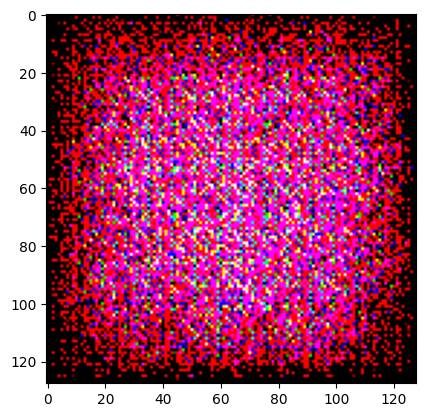

In [33]:
# Training Loop
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import matplotlib.pyplot as plt

alias = None
writer = SummaryWriter("summaries/{}".format(alias))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(dataloader), 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D_model.zero_grad()

        # Для батча
        real_cpu = batch.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = D_model(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Учим на полном фейковом батче
        noise = torch.randn(b_size, nz, device=device)
        fake = G_model(noise)
        label.fill_(fake_label)

        m = (torch.min(fake), torch.max(fake))

        output = D_model(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        D_optim.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        G_model.zero_grad()
        label.fill_(
            real_label
        )  # для генератора фейковые метки есть реальные (0 меняем на 1)
        output = D_model(fake).view(-1)

        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD,
                    errG,
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

            img = fake[0].permute(1, 2, 0).detach().numpy()
            img[img < 0] = 0.0
            plt.imshow(img * 255)
            plt.savefig(f"res/{epoch}_{i}.png")

        # Сохраним лоссы
        G_losses.append(errG)
        D_losses.append(errD)

        writer.add_scalars(
            "train/epoch/", {"generator_loss": errG, "discriminator_loss": errD}, epoch
        )
        iters += 1

    print(f"epotch: {epoch}  G_loss: {G_losses}  D_loss: {D_losses}")

In [ ]:
import torch

torch.cuda.is_available()

False

In [ ]:
# Проверим какие картинки рисует генератор
with torch.no_grad():
    fake = G_model(noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


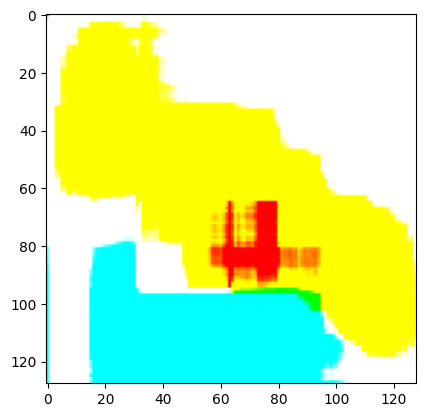

In [ ]:
import matplotlib.pyplot as plt

# img_list[0].shape
plt.imshow(fake[1].permute(1, 2, 0))